## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Семенов |
|---------|---------|
| Группа  | 6       |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [21]:
#!wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (35) schannel: next InitializeSecurityContext failed: Unknown error (0x80092012) - Функция отзыва не смогла произвести проверку отзыва для сертификата.
gzip: mnist.pkl.gz: No such file or directory


Теперь загружаем датасет:

In [22]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [23]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

Смотрим на то, какие данные получились:

In [24]:
data.shape

(42000, 784)

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

Датасет загружен, теперь можно его нормализовать

In [37]:
X_test = X_test / 255.0
X_train = X_train / 255.0

Для последующей обработки данных, нужно определеить нейросеть и слои, которые могут в нее войти.
Нам понадобятся линейные слои, softmax, tanh, и cross_entropy_loss
Также полезным будет класс Trainer(хотя это могла быть и функция), которая проводит обучение в течение нескольких эпох. Для отрисовки используется класс Plotter(принимает массив со значениями функции потерь и accuracy)

In [38]:
import numpy as np

class Linear:
    def __init__(self, nin, nout):
        self.W = np.random.normal(0, 1.0 / np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1, nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b

    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx

    def update(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db


class Softmax:
    def forward(self, z):
        self.z = z
        zmax = z.max(axis=1, keepdims=True)
        expz = np.exp(z - zmax)
        Z = expz.sum(axis=1, keepdims=True)
        return expz / Z

    def backward(self, dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)


class CrossEntropyLoss:
    def forward(self, p, y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()

    def backward(self, loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0 / len(self.y)
        return dlog_softmax / self.p

class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

In [39]:
class Net:
    def __init__(self, lr=0.1, final_loss=CrossEntropyLoss()):
        self.layers = []
        self.final_loss = final_loss
        self.lr = lr

    def add(self, l):
        self.layers.append(l)

    def set_final_loss(self, loss):
        self.final_loss = loss

    def set_learning_rate(self, lr):
        self.lr = lr

    def forward(self, X):
        for l in self.layers:
            X = l.forward(X)
        return X

    def predict(self, X):
        p = self.forward(X)
        pred = np.argmax(p, axis=1)
        return pred

    def loss_n_accuracy(self, X, y, loss=None):
        if loss is None:
            loss = self.final_loss
        p = self.forward(X)
        l = loss.forward(p, y)
        pred = np.argmax(p, axis=1)
        acc = (pred==y).mean()
        return l, acc

    def train_epoch(self, X, y, batch_size=4):
        for i in range(0, len(X), batch_size):
            Xb = X[i:i + batch_size]
            yb = y[i:i + batch_size]

            p = self.forward(Xb)
            l = self.final_loss.forward(p, yb)
            dp = self.final_loss.backward(l)
            dx = self.backward(dp)
            self.update()


    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z

    def update(self):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(self.lr)

In [40]:
class Trainer():
    def __init__(self, net):
        self.net = net

    def train_epochs(self, X, y, X_test, y_test, n_epoch, batch_size=4, loss=None):

        train_acc = np.empty((n_epoch + 1, 3))
        train_acc[0] = [0,0,0]
        valid_acc = np.empty((n_epoch + 1, 3))
        valid_acc[0] = [0,0,0]

        for epoch in range(1, n_epoch + 1):
            self.net.train_epoch(X, y)
            tloss, tacc = self.net.loss_n_accuracy(X, y, loss)
            train_acc[epoch, :] = [epoch, tloss, tacc]
            vloss, vacc = self.net.loss_n_accuracy(X_test, y_test, loss)
            valid_acc[epoch, :] = [epoch, vloss, vacc]

        return train_acc, valid_acc

In [41]:
import matplotlib.pyplot as plt
class Plotter():

    def __plot_training_progress__(self, X, y, fig, ax):
        styles = ['k--', 'g-']
        # remove previous plot
        while ax.lines:
            ax.lines.pop()
        # draw updated lines
        for i in range(len(y)):
            ax.plot(X, y[i], styles[i])
        ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],
                  loc='upper center', ncol=2)


    def plot(self, train_acc, valid_acc):
        n_epoch = len(train_acc)
        fig, ax = plt.subplots(1,1)
        ax.set_xlim(0, n_epoch + 1)
        ax.set_ylim(0, 1)
        ax.set_ylim(0, max(max(train_acc[:, 2]), max(valid_acc[:, 2])) * 1.1)
        self.__plot_training_progress__(train_acc[:, 0], (train_acc[:, 2],
                                                     valid_acc[:, 2]), fig, ax)
        fig.canvas.draw()
        fig.canvas.flush_events()

Создадим однослойную нейросеть, состоящую из линейного слоя и Softmax для обработки датасета MNIST. CrossEntropyLoss добавляется в конец сети автоматически, но при необходимости, она может быть заменена на другую функцию. Заодно обучим ее в течение нескольких эпох и выведем confusion matrix - позволяет увидеть количество ложных/верных предсказаний для различных классов.

Accuracy on last epoch 0.919404761904762
[[779   0   8   5   2  12   4   6   4  13]
 [  0 938   6   3   7   3   0   4   9   4]
 [  2   5 769  16   3   1   7  12   3   2]
 [  2   3  12 771   2  27   1   4  21   8]
 [  3   0  14   1 768   6  10   9   2  30]
 [  5   4   4  36   2 664  12   2  28   8]
 [ 14   2  15   6  11  10 806   1   9   0]
 [  0   1  12   6   1   5   0 830   3  25]
 [  7   7  18   8   2  23   1   3 680   4]
 [  1   1   2  11  29   5   0  28   9 718]]


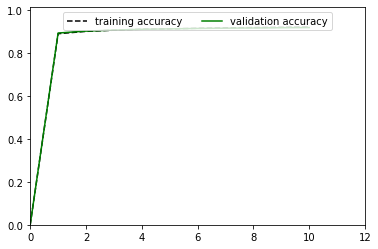

In [42]:
net = Net(lr=0.005)
net.add(Linear(28**2, 10))
net.add(Softmax())

trainer = Trainer(net)
tacc, vacc = trainer.train_epochs(X_train, y_train, X_test, y_test, 10)
Plotter().plot(tacc, vacc)
print("Accuracy on last epoch {}".format(vacc[-1,-1]))
print(confusion_matrix(net.predict(X_test), y_test))
plt.show()

Теперь, загрузим датасет FashionMNIST и опробуем на нем двуслойную сеть(на процессоре она уже обучается достаточно долго).

In [44]:
import tensorflow as tf
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

Accuracy on last epoch 0.8611
[[777   1   7  15   0   0 106   0   1   0]
 [  1 957   1   8   1   0   1   0   1   0]
 [ 26   2 738  11  71   0 103   0   4   0]
 [ 71  32  18 921  57   1  62   0   8   0]
 [  8   4 170  24 820   0  94   0   5   0]
 [  2   0   1   1   0 943   1  34   3  17]
 [ 97   2  53  16  46   0 602   0   2   0]
 [  0   0   0   0   0  39   0 950   4  51]
 [ 18   2  12   4   5   2  31   0 972   1]
 [  0   0   0   0   0  15   0  16   0 931]]


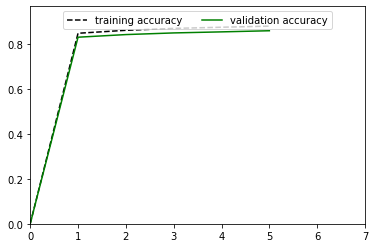

In [45]:
net = Net(lr=0.01)
net.add(Linear(28**2, 28**2 // 2))
net.add(Tanh())
net.add(Linear(28**2 // 2, 10))
net.add(Softmax())

X_train = X_train.reshape(X_train.shape[0], 28**2)
X_test = X_test.reshape(X_test.shape[0], 28**2)

trainer = Trainer(net)
tacc, vacc = trainer.train_epochs(X_train, y_train, X_test, y_test, 5)
Plotter().plot(tacc, vacc)
print("Accuracy on last epoch {}".format(vacc[-1,-1]))
print(confusion_matrix(net.predict(X_test), y_test))
plt.show()

Заметно, что точность несколько уменьшилась.

Благодаря данной работе я узнал об устройстве многослойного персептрона, способах его обучения и используемом для этого математическом аппарате.